# Tanítás tőzsdei záró értékek felhasználásával

In [5]:
import torch
from pytorch_forecasting.models.nbeats import NBeats
from pytorch_forecasting.models.nhits import NHiTS
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from sklearn.preprocessing import StandardScaler
from pytorch_forecasting import TimeSeriesDataSet, NHiTS, NBeats, TemporalFusionTransformer
import sqlite3
import os
import mlflow
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from pytorch_forecasting.data import GroupNormalizer
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping

import time

import numpy as np

import matplotlib.pyplot as plt

In [7]:

conn = sqlite3.connect("../data_pipeline/stock_data.db")

stock_data = pd.read_sql("SELECT * FROM OTP_BD", conn)
conn.close()

print("Data read back from SQL:")
print()
stock_data

Data read back from SQL:



,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Scaled_price,sentiment_score
0,2002-03-05,1346.679102,1404.393921,1335.136138,1404.393921,1726700,0.0,0.0,-1.009421,0.0
1,2002-03-06,1396.057389,1443.511797,1379.384219,1436.457764,898300,0.0,0.0,-1.003618,0.0
2,2002-03-07,1449.924288,1474.934039,1437.098775,1471.727661,763700,0.0,0.0,-0.997235,0.0
3,2002-03-08,1452.489264,1463.390950,1438.381201,1462.108398,402000,0.0,0.0,-0.998976,1.0
4,2002-03-11,1445.435476,1448.641854,1379.384076,1384.514282,439600,0.0,0.0,-1.013019,1.0
...,...,...,...,...,...,...,...,...,...,...
6040,2025-10-15,30200.000000,30640.000000,30200.000000,30430.000000,333078,0.0,0.0,4.243485,2.0
6041,2025-10-16,30450.000000,30780.000000,30360.000000,30630.000000,290776,0.0,0.0,4.279680,1.0
6042,2025-10-17,30350.000000,30480.000000,30130.000000,30330.000000,268702,0.0,0.0,4.225388,2.0
6043,2025-10-20,30410.000000,30750.000000,30410.000000,30650.000000,166529,0.0,0.0,4.283300,0.0


In [8]:
stock_data['time_idx'] = range(len(stock_data))

stock_data["series"] = 0

In [ ]:
mlflow.set_tracking_uri('http://localhost:5000')

mlflow.set_experiment("Base_models")

train_cutoff = int(len(stock_data) * 0.8)
max_encoder_length = 60
max_prediction_length = 30

common_params = dict(
    time_idx="time_idx",
    target="Scaled_price",
    categorical_encoders={"series": NaNLabelEncoder(add_nan=True).fit(stock_data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=["Scaled_price"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
)

train_val_data = stock_data[stock_data.time_idx <= train_cutoff]
test_data = stock_data[stock_data.time_idx > train_cutoff]


val_cutoff = int(train_val_data["time_idx"].quantile(0.9))

train_dataset = TimeSeriesDataSet(
    train_val_data[train_val_data.time_idx <= val_cutoff],
    **common_params
)

val_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    train_val_data[train_val_data.time_idx > val_cutoff],
    predict=True,
    stop_randomization=True
)

test_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    test_data,
    predict=True,
    stop_randomization=True,
    )


train_dataloader = train_dataset.to_dataloader(train=False, batch_size=32, num_workers=0, shuffle=False)
val_dataloader = val_dataset.to_dataloader(train=False, batch_size=32, num_workers=0, shuffle=False)
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=32, num_workers=0, shuffle=False)

models = {
    "LSTM_Keras": None,
    "N-BEATS": NBeats,
    "N-HITS": NHiTS,
    "Transformer": TemporalFusionTransformer
}

results = {}

for model_name, model_class in models.items():
    with mlflow.start_run(run_name=model_name):
        print(f"\n=== Training {model_name} ===")
        if model_name == "LSTM_Keras":
            series = stock_data['Scaled_price'].values

            def create_sequences(series, start_idx, end_idx):
                X, y = [], []
                for i in range(start_idx + max_encoder_length, end_idx - max_prediction_length):
                    X.append(series[i - max_encoder_length:i])
                    y.append(series[i:i + max_prediction_length])
                return np.array(X), np.array(y)

            train_X, train_y = create_sequences(series, 0, train_cutoff)
            test_X, test_y = create_sequences(series, train_cutoff, len(series))

            train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))

            lstm_model = Sequential([
                Input(shape = (max_encoder_length, 1)),
                LSTM(units = 50, return_sequences = True),
                LSTM(50),
                Dense(max_prediction_length, activation='linear')
            ])
            lstm_model.compile(loss = 'mean_squared_error', optimizer = 'adam')
            lstm_model.fit(train_X, train_y,  epochs=20, batch_size=32, 
                    verbose=1, validation_split=0.1,)

            train_pred = lstm_model.predict(train_X)
            train_rmse = root_mean_squared_error(train_y, train_pred)

            test_pred = lstm_model.predict(test_X)
            test_rmse = root_mean_squared_error(test_y, test_pred)

            test_mse = mean_squared_error(test_y, test_pred)

            test_mape = mean_absolute_percentage_error(test_y, test_pred)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.log_metric("test_mse", test_mse)
            mlflow.log_metric("test_mape", test_mape)
            mlflow.keras.log_model(lstm_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
            lstm_model.save('models/lstm_model_base.keras')
        
        elif model_name == "N-BEATS":
            nbeats_model = NBeats.from_dataset(  
                train_dataset,  
                learning_rate=1e-3,  
                weight_decay=1e-3,  
                widths=[256, 512],  
                backcast_loss_ratio=0.1,  
                num_blocks=[4,4], 
                num_block_layers=[4,4],
            )
            trainer = Trainer(max_epochs=20, gradient_clip_val=0.1, logger=False, enable_checkpointing=False)
            trainer.fit(nbeats_model, train_dataloader)

            actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
            predictions = nbeats_model.predict(train_dataloader)
            train_rmse = np.sqrt(torch.mean((actuals - predictions[:len(actuals)]) ** 2)).item()

            test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
            test_predictions = nbeats_model.predict(test_dataloader)

            test_rmse = root_mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mse = mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mape = mean_absolute_percentage_error(test_actuals, test_predictions[:len(test_actuals)])
            # test_rmse = np.sqrt(torch.mean((test_actuals - test_predictions[:len(test_actuals)]) ** 2)).item()

            total_params = sum(p.numel() for p in nbeats_model.parameters() if p.requires_grad)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.log_metric("test_mse", test_mse)
            mlflow.log_metric("test_mape", test_mape)
            mlflow.log_metric("total_parameters", total_params)
            mlflow.pytorch.log_model(nbeats_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
            torch.save(nbeats_model.state_dict(), "models/nbeats_weights_base.pth")

        elif model_name == "N-HITS":
            nhits_model = NHiTS.from_dataset(
                train_dataset,
                learning_rate=1e-3,  
                log_interval=10,  
                log_val_interval=1,  
                weight_decay=0.001,  
                n_blocks=[3, 3, 3],  
                n_layers=2,  
                hidden_size=512,  
                dropout=0.1,  
            )
            trainer = Trainer(max_epochs=20, gradient_clip_val=0.1, logger=False, enable_checkpointing=False)
            trainer.fit(nhits_model, train_dataloader)

            actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
            predictions = nhits_model.predict(train_dataloader)
            train_rmse = np.sqrt(torch.mean((actuals - predictions[:len(actuals)]) ** 2)).item()

            test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
            test_predictions = nhits_model.predict(test_dataloader)
            # test_rmse = np.sqrt(torch.mean((test_actuals - test_predictions[:len(test_actuals)]) ** 2)).item()
            test_rmse = root_mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mse = mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mape = mean_absolute_percentage_error(test_actuals, test_predictions[:len(test_actuals)])
            total_params = sum(p.numel() for p in nhits_model.parameters() if p.requires_grad)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.log_metric("test_mse", test_mse)
            mlflow.log_metric("test_mape", test_mape)
            mlflow.log_metric("total_parameters", total_params)
            mlflow.pytorch.log_model(nhits_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
            torch.save(nhits_model.state_dict(), "models/nhits_weights_base.pth")

        else:
            transformer_model = TemporalFusionTransformer.from_dataset(
                train_dataset,
                hidden_size=64,
                lstm_layers=1,
                dropout=0.15,
                attention_head_size=4,
                learning_rate=1e-3
            )
            trainer = Trainer(max_epochs=20, gradient_clip_val=0.1, logger=False, enable_checkpointing=False)
            trainer.fit(transformer_model, train_dataloader)

            actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
            predictions = transformer_model.predict(train_dataloader)
            train_rmse = np.sqrt(torch.mean((actuals - predictions[:len(actuals)]) ** 2)).item()

            test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
            test_predictions = transformer_model.predict(test_dataloader)
            test_rmse = root_mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mse = mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mape = mean_absolute_percentage_error(test_actuals, test_predictions[:len(test_actuals)])
            # test_rmse = np.sqrt(torch.mean((test_actuals - test_predictions[:len(test_actuals)]) ** 2)).item()

            total_params = sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.log_metric("test_mse", test_mse)
            mlflow.log_metric("test_mape", test_mape)
            mlflow.log_metric("total_parameters", total_params)
            mlflow.pytorch.log_model(transformer_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
            torch.save(transformer_model.state_dict(), "models/transformer_weights_base.pth")

print("\n=== RMSE Results ===")
for model_name, rmse_values in results.items():
    print(f"{model_name} => Train RMSE: {rmse_values['train_rmse']:.4f}, Test RMSE: {rmse_values['test_rmse']:.4f}")


2025/11/06 18:08:11 INFO mlflow.tracking.fluent: Experiment with name 'Base_models' does not exist. Creating a new experiment.



=== Training LSTM_Keras ===
Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0399 - val_loss: 0.0867
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0057 - val_loss: 0.0752
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0053 - val_loss: 0.0662
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0052 - val_loss: 0.0625
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0050 - val_loss: 0.0635
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0048 - val_loss: 0.0601
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0048 - val_loss: 0.0617
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0047 - val_loss: 0.0589
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0047 - val_loss: 0.0555
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0047 - val_loss: 0.0537
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0046 - val_loss: 0.0519
Epoch 12/20


2025/11/06 18:09:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/06 18:09:23 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/06 18:09:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
G

🏃 View run LSTM_Keras at: http://localhost:5000/#/experiments/219186714992998273/runs/86b06ae99ce548d8bafd5fd5333ceb25
🧪 View experiment at: http://localhost:5000/#/experiments/219186714992998273

=== Training N-BEATS ===
Epoch 1:   2%|▏         | 3/134 [00:00<00:07, 16.95it/s, train_loss_step=2.750, train_loss_epoch=4.980]  

c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\loops\training_epoch_loop.py:492: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 19: 100%|██████████| 134/134 [00:06<00:00, 20.06it/s, train_loss_step=2.960, train_loss_epoch=4.190]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 134/134 [00:06<00:00, 20.05it/s, train_loss_step=2.960, train_loss_epoch=4.190]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\veres\AppData\Local\Temp\ipykernel_12076\3817925622.py:120: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(torch.mean((actuals - predictions[:len(actuals)]) ** 2)).item()
💡 Tip: For seamless cloud uploads and versioning, try installing [

🏃 View run N-BEATS at: http://localhost:5000/#/experiments/219186714992998273/runs/31cbfe814f634e35994174b9ea61f7fc
🧪 View experiment at: http://localhost:5000/#/experiments/219186714992998273

=== Training N-HITS ===
Epoch 1:   4%|▎         | 5/134 [00:00<00:05, 25.66it/s, train_loss_step=2.640, train_loss_epoch=4.600]  

c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\loops\training_epoch_loop.py:492: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 19: 100%|██████████| 134/134 [00:05<00:00, 25.59it/s, train_loss_step=2.660, train_loss_epoch=3.950]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 134/134 [00:05<00:00, 25.58it/s, train_loss_step=2.660, train_loss_epoch=3.950]


c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\veres\AppData\Local\Temp\ipykernel_12076\3817925622.py:160: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(torch.mean((actuals - predictions[:len(actuals)]) ** 2)).item()
2025/11/06 18:14:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/06 18:14:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch

🏃 View run N-HITS at: http://localhost:5000/#/experiments/219186714992998273/runs/06006e15340a4a7f97f0e176f39735b7
🧪 View experiment at: http://localhost:5000/#/experiments/219186714992998273

=== Training Transformer ===
Epoch 1:   1%|▏         | 2/134 [00:00<00:12, 10.84it/s, train_loss_step=0.00714, train_loss_epoch=0.0352] 

c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\loops\training_epoch_loop.py:492: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 19: 100%|██████████| 134/134 [00:12<00:00, 11.02it/s, train_loss_step=0.0318, train_loss_epoch=0.0253]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 134/134 [00:12<00:00, 11.02it/s, train_loss_step=0.0318, train_loss_epoch=0.0253]


c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\veres\AppData\Local\Temp\ipykernel_12076\3817925622.py:195: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(torch.mean((actuals - predictions[:len(actuals)]) ** 2)).item()
2025/11/06 18:18:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/06 18:18:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Transformer at: http://localhost:5000/#/experiments/219186714992998273/runs/10c496d7ea0e44eeb28353e0bc303016
🧪 View experiment at: http://localhost:5000/#/experiments/219186714992998273

=== RMSE Results ===
LSTM_Keras => Train RMSE: 0.0877, Test RMSE: 1.1903
N-BEATS => Train RMSE: 0.0749, Test RMSE: 0.1760
N-HITS => Train RMSE: 0.0686, Test RMSE: 0.1132
Transformer => Train RMSE: 0.0680, Test RMSE: 0.2203


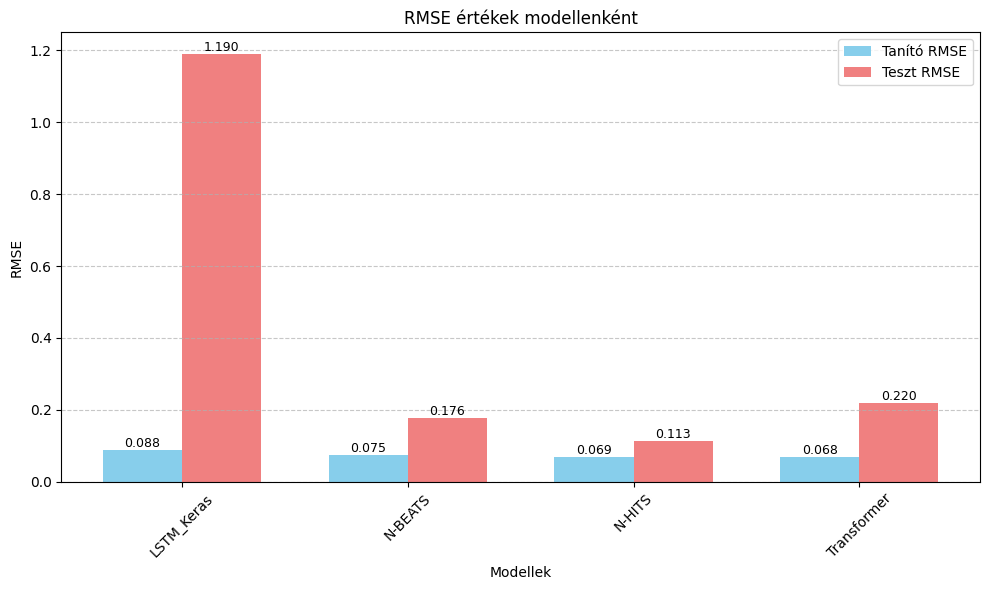

In [10]:
import matplotlib.pyplot as plt
import numpy as np

models = list(results.keys())
train_rmse = [results[model]['train_rmse'] for model in models]
val_rmse = [results[model]['test_rmse'] for model in models]

plt.figure(figsize=(10, 6))

x = np.arange(len(models))
width = 0.35  

bars1 = plt.bar(x - width/2, train_rmse, width, label='Tanító RMSE', color='skyblue')
bars2 = plt.bar(x + width/2, val_rmse, width, label='Teszt RMSE', color='lightcoral')

plt.xlabel('Modellek')
plt.ylabel('RMSE')
plt.title('RMSE értékek modellenként')
plt.xticks(x, models, rotation=45)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

for bar in bars1:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, height,
        f'{height:.3f}',
        ha='center', va='bottom', fontsize=9
    )

for bar in bars2:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, height,
        f'{height:.3f}',
        ha='center', va='bottom', fontsize=9
    )

plt.tight_layout()
plt.show()


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


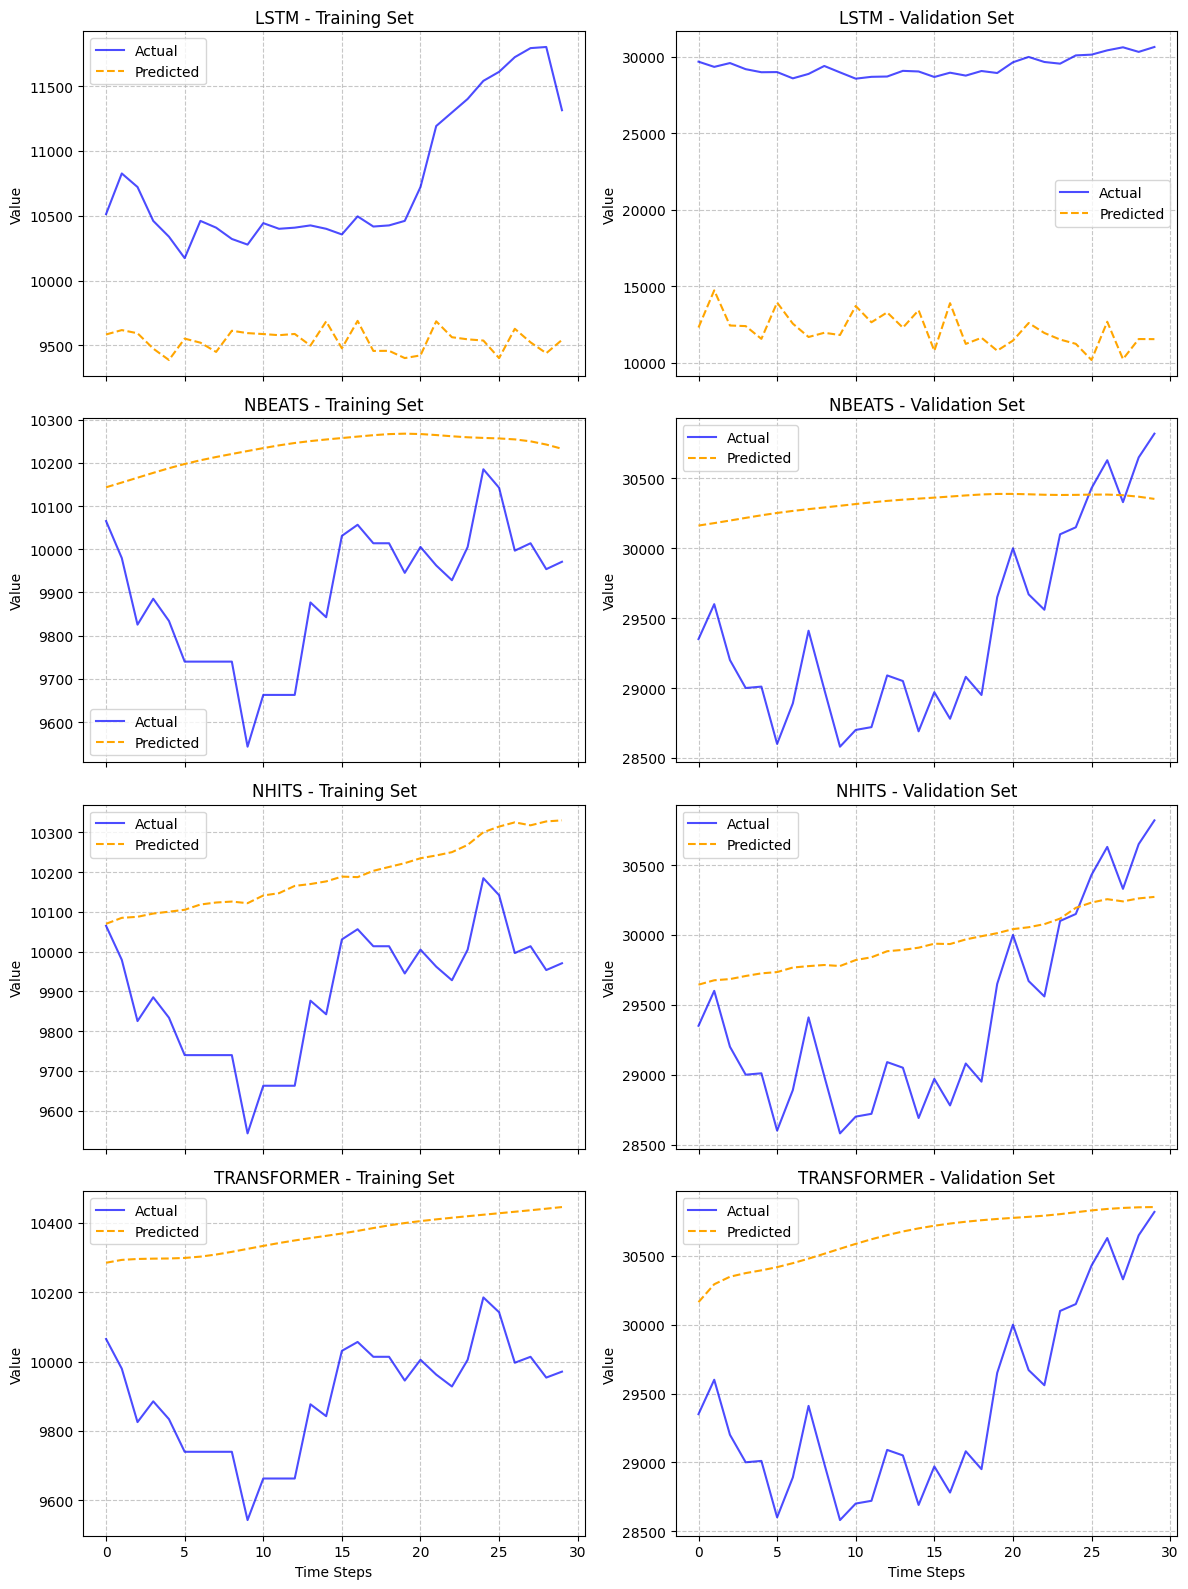

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import joblib

# Assuming model_names is defined as provided
model_names = {"lstm": lstm_model, "nbeats": nbeats_model, "nhits": nhits_model, "transformer": transformer_model}

scaler = joblib.load("../data_pipeline/scaler_model.pkl")

# Initialize dictionaries to store predictions
train_predictions = {}
test_predictions = {}
train_actuals = {}
test_actuals = {}

# Generate predictions for each model
for name in model_names:
    if name == "lstm":
        # LSTM predictions (Keras)
        train_pred = lstm_model.predict(train_X)
        test_pred = lstm_model.predict(test_X)
        # Inverse transform to original scale
        train_predictions[name] = scaler.inverse_transform(train_pred)[-1]
        test_predictions[name] = scaler.inverse_transform(test_pred)[-1]
        train_actuals[name] = scaler.inverse_transform(train_y)[-1]
        test_actuals[name] = scaler.inverse_transform(test_y)[-1]
    else:
        # PyTorch-based models (nbeats, nhits, transformer)
        model = model_names[name]
        # Generate predictions
        train_pred = model.predict(train_dataloader).detach().numpy()
        test_pred = model.predict(test_dataloader).detach().numpy()
        # Get actuals
        train_actual = torch.cat([y[0] for x, y in iter(train_dataloader)]).numpy()
        test_actual = torch.cat([y[0] for x, y in iter(test_dataloader)]).numpy()
        train_predictions[name] = scaler.inverse_transform(train_pred)[-1]
        test_predictions[name] = scaler.inverse_transform(test_pred)[-1]
        train_actuals[name] = scaler.inverse_transform(train_actual)[-1]
        test_actuals[name] = scaler.inverse_transform(test_actual)[-1]

# Set up the figure with subplots for each model
fig, axes = plt.subplots(len(model_names), 2, figsize=(12, 4 * len(model_names)), sharex=True)

# Plot predictions vs actuals for each model
for idx, name in enumerate(model_names):
    # Training set plot
    axes[idx][0].plot(train_actuals[name], label='Actual', color='blue', alpha=0.7)
    axes[idx][0].plot(train_predictions[name], label='Predicted', color='orange', linestyle='--')
    axes[idx][0].set_title(f'{name.upper()} - Training Set')
    axes[idx][0].set_ylabel('Value')
    axes[idx][0].legend()
    axes[idx][0].grid(True, linestyle='--', alpha=0.7)

    # Validation set plot
    axes[idx][1].plot(test_actuals[name], label='Actual', color='blue', alpha=0.7)
    axes[idx][1].plot(test_predictions[name], label='Predicted', color='orange', linestyle='--')
    axes[idx][1].set_title(f'{name.upper()} - Validation Set')
    axes[idx][1].set_ylabel('Value')
    axes[idx][1].legend()
    axes[idx][1].grid(True, linestyle='--', alpha=0.7)

# Set common x-label and adjust layout
for ax in axes[-1]:
    ax.set_xlabel('Time Steps')
plt.tight_layout()

# Show the plot
plt.show()

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


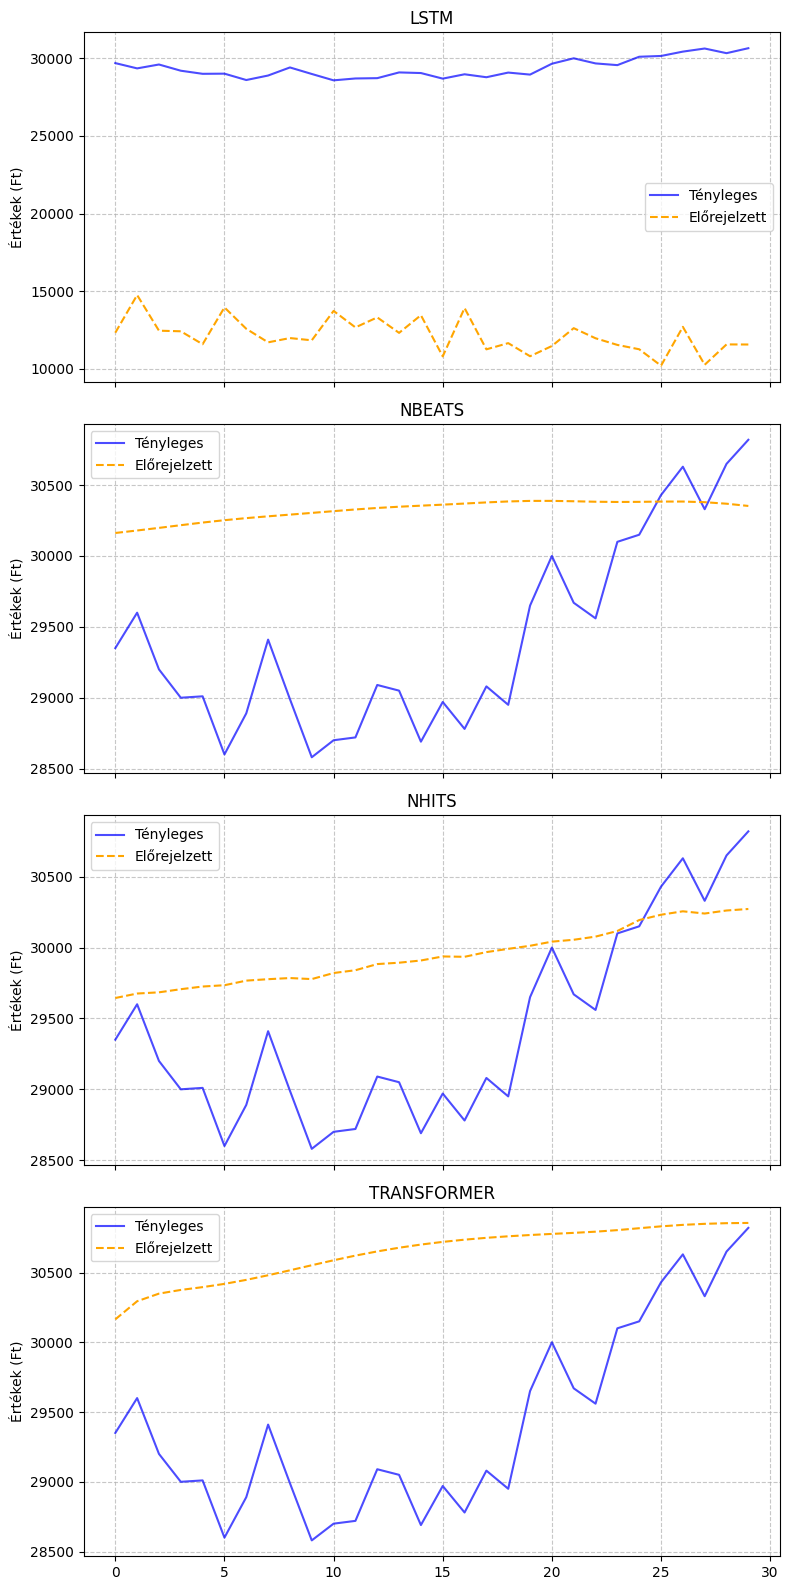

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import joblib

# Assuming model_names is defined as provided
model_names = {"lstm": lstm_model, "nbeats": nbeats_model, "nhits": nhits_model, "transformer": transformer_model}

scaler = joblib.load("../data_pipeline/scaler_model.pkl")

# Initialize dictionaries to store predictions
train_predictions = {}
test_predictions = {}
train_actuals = {}
test_actuals = {}

# Generate predictions for each model
for name in model_names:
    if name == "lstm":
        # LSTM predictions (Keras)
        train_pred = lstm_model.predict(train_X)
        test_pred = lstm_model.predict(test_X)
        # Inverse transform to original scale
        train_predictions[name] = scaler.inverse_transform(train_pred)[-1]
        test_predictions[name] = scaler.inverse_transform(test_pred)[-1]
        train_actuals[name] = scaler.inverse_transform(train_y)[-1]
        test_actuals[name] = scaler.inverse_transform(test_y)[-1]
    else:
        # PyTorch-based models (nbeats, nhits, transformer)
        model = model_names[name]
        # Generate predictions
        train_pred = model.predict(train_dataloader).detach().numpy()
        test_pred = model.predict(test_dataloader).detach().numpy()
        # Get actuals
        train_actual = torch.cat([y[0] for x, y in iter(train_dataloader)]).numpy()
        test_actual = torch.cat([y[0] for x, y in iter(test_dataloader)]).numpy()
        train_predictions[name] = scaler.inverse_transform(train_pred)[-1]
        test_predictions[name] = scaler.inverse_transform(test_pred)[-1]
        train_actuals[name] = scaler.inverse_transform(train_actual)[-1]
        test_actuals[name] = scaler.inverse_transform(test_actual)[-1]

fig, axes = plt.subplots(len(model_names), 1, figsize=(8, 4 * len(model_names)), sharex=True)

for idx, name in enumerate(model_names):

    axes[idx].plot(test_actuals[name], label='Tényleges', color='blue', alpha=0.7)
    axes[idx].plot(test_predictions[name], label='Előrejelzett', color='orange', linestyle='--')
    axes[idx].set_title(f'{name.upper()}')
    axes[idx].set_ylabel('Értékek (Ft)')
    axes[idx].legend()
    axes[idx].grid(True, linestyle='--', alpha=0.7)


plt.tight_layout()

plt.show()

## Újra tanítás a hibák kiértékelése után

In [14]:
from tensorflow.keras.callbacks import EarlyStopping as LSTMEarlyStop

mlflow.set_tracking_uri('http://localhost:5000')

mlflow.set_experiment("Base_models_finetuned")

train_cutoff = int(len(stock_data) * 0.8)
max_encoder_length = 60
max_prediction_length = 30

common_params = dict(
    time_idx="time_idx",
    target="Scaled_price",
    categorical_encoders={"series": NaNLabelEncoder(add_nan=True).fit(stock_data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=["Scaled_price"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
)

train_val_data = stock_data[stock_data.time_idx <= train_cutoff]
test_data = stock_data[stock_data.time_idx > train_cutoff]


val_cutoff = int(train_val_data["time_idx"].quantile(0.9))

train_dataset = TimeSeriesDataSet(
    train_val_data[train_val_data.time_idx <= val_cutoff],
    **common_params
)

val_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    train_val_data[train_val_data.time_idx > val_cutoff],
    predict=True,
    stop_randomization=True
)

test_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    test_data,
    predict=True,
    stop_randomization=True,
    )


train_dataloader = train_dataset.to_dataloader(train=False, batch_size=32, num_workers=0, shuffle=False)
val_dataloader = val_dataset.to_dataloader(train=False, batch_size=32, num_workers=0, shuffle=False)
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=32, num_workers=0, shuffle=False)

models = {
    "LSTM_Keras": None,
    "N-BEATS": NBeats,
    "N-HITS": NHiTS,
    "Transformer": TemporalFusionTransformer
}

results = {}

for model_name, model_class in models.items():
    with mlflow.start_run(run_name=model_name):
        print(f"\n=== Training {model_name} ===")
        if model_name == "LSTM_Keras":
            series = stock_data['Scaled_price'].values

            def create_sequences(series, start_idx, end_idx):
                X, y = [], []
                for i in range(start_idx + max_encoder_length, end_idx - max_prediction_length):
                    X.append(series[i - max_encoder_length:i])
                    y.append(series[i:i + max_prediction_length])
                return np.array(X), np.array(y)

            train_X, train_y = create_sequences(series, 0, train_cutoff)
            val_X, val_y = create_sequences(series, train_cutoff, len(series))

            train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
            val_X = val_X.reshape((val_X.shape[0], val_X.shape[1], 1))

            lstm_model = Sequential([
                Input(shape = (max_encoder_length, 1)),
                LSTM(units = 50, return_sequences = True),
                LSTM(50),
                Dense(max_prediction_length, activation='linear')
            ])
            lstm_model.compile(loss = 'mean_squared_error', optimizer = 'adam')

            early_stopping = LSTMEarlyStop(
                monitor='val_loss',
                patience=20,
                restore_best_weights=True
            )

            lstm_model.fit(train_X, 
                           train_y, 
                           epochs=500, 
                           batch_size=32, 
                           verbose=1, 
                           validation_split=0.1, 
                           callbacks=[early_stopping]
                        )

            train_pred = lstm_model.predict(train_X)
            train_rmse = root_mean_squared_error(train_y, train_pred)

            test_pred = lstm_model.predict(test_X)
            test_rmse = root_mean_squared_error(test_y, test_pred)

            test_mse = mean_squared_error(test_y, test_pred)

            test_mape = mean_absolute_percentage_error(test_y, test_pred)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.log_metric("test_mse", test_mse)
            mlflow.log_metric("test_mape", test_mape)
            mlflow.keras.log_model(lstm_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
            lstm_model.save('models/lstm_model_base_v2.keras')
        
        elif model_name == "N-BEATS":
            nbeats_model = NBeats.from_dataset(  
                train_dataset,  
                learning_rate=1e-3,  
                weight_decay=1e-3,  
                widths=[256, 512],  
                backcast_loss_ratio=0.1,  
                num_blocks=[4,4], 
                num_block_layers=[4,4],
            )

            early_stopping = EarlyStopping(
                monitor="val_loss",          
                patience=20,                 
                min_delta=1e-4,              
                mode="min", 
                verbose=True
            )

            trainer = Trainer(
                max_epochs=500,
                gradient_clip_val=0.1,
                logger=False,
                enable_checkpointing=False,
                callbacks=[early_stopping]  
            )
            # trainer = Trainer(max_epochs=200, gradient_clip_val=0.1, logger=False, enable_checkpointing=False)
            trainer.fit(nbeats_model, train_dataloader, val_dataloader)

            actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
            predictions = nbeats_model.predict(train_dataloader)

            test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
            test_predictions = nbeats_model.predict(test_dataloader)

            train_rmse = root_mean_squared_error(actuals, predictions[:len(actuals)])
            test_rmse = root_mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mse = mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mape = mean_absolute_percentage_error(test_actuals, test_predictions[:len(test_actuals)])
            # test_rmse = np.sqrt(torch.mean((test_actuals - test_predictions[:len(test_actuals)]) ** 2)).item()

            total_params = sum(p.numel() for p in nbeats_model.parameters() if p.requires_grad)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.log_metric("test_mse", test_mse)
            mlflow.log_metric("test_mape", test_mape)
            mlflow.log_metric("total_parameters", total_params)
            mlflow.pytorch.log_model(nbeats_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
            torch.save(nbeats_model.state_dict(), "models/nbeats_weights_base_v2.pth")

        elif model_name == "N-HITS":
            nhits_model = NHiTS.from_dataset(
                train_dataset,
                learning_rate=1e-3,  
                log_interval=10,  
                log_val_interval=1,  
                weight_decay=0.001,  
                n_blocks=[3, 3, 3],  
                n_layers=2,  
                hidden_size=512,  
                dropout=0.1,  
            )

            early_stopping = EarlyStopping(
                monitor="val_loss",          
                patience=20,                 
                min_delta=1e-4,              
                mode="min", 
                verbose=True
            )

            trainer = Trainer(
                max_epochs=500,
                gradient_clip_val=0.1,
                logger=False,
                enable_checkpointing=False,
                callbacks=[early_stopping]  
            )
            # trainer = Trainer(max_epochs=200, gradient_clip_val=0.1, logger=False, enable_checkpointing=False)
            trainer.fit(nhits_model, train_dataloader, val_dataloader)

            actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
            predictions = nhits_model.predict(train_dataloader)

            test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
            test_predictions = nhits_model.predict(test_dataloader)

            train_rmse = root_mean_squared_error(actuals, predictions[:len(actuals)])
            test_rmse = root_mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mse = mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mape = mean_absolute_percentage_error(test_actuals, test_predictions[:len(test_actuals)])
            # test_rmse = np.sqrt(torch.mean((test_actuals - test_predictions[:len(test_actuals)]) ** 2)).item()

            total_params = sum(p.numel() for p in nhits_model.parameters() if p.requires_grad)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.log_metric("test_mse", test_mse)
            mlflow.log_metric("test_mape", test_mape)
            mlflow.log_metric("total_parameters", total_params)
            mlflow.pytorch.log_model(nhits_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
            torch.save(nhits_model.state_dict(), "models/nhits_weights_base_v2.pth")

        else:
            transformer_model = TemporalFusionTransformer.from_dataset(
                train_dataset,
                hidden_size=64,
                lstm_layers=1,
                dropout=0.15,
                attention_head_size=4,
                learning_rate=1e-3
            )
            
            early_stopping = EarlyStopping(
                monitor="val_loss",          
                patience=20,                 
                min_delta=1e-4,              
                mode="min", 
                verbose=True
            )

            trainer = Trainer(
                max_epochs=500,
                gradient_clip_val=0.1,
                logger=False,
                enable_checkpointing=False,
                callbacks=[early_stopping]  
            )

            # trainer = Trainer(max_epochs=200, gradient_clip_val=0.1, logger=False, enable_checkpointing=False)
            trainer.fit(transformer_model, train_dataloader, val_dataloader)

            actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
            predictions = transformer_model.predict(train_dataloader)
            

            test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
            test_predictions = transformer_model.predict(test_dataloader)

            train_rmse = root_mean_squared_error(actuals, predictions[:len(actuals)])
            test_rmse = root_mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mse = mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mape = mean_absolute_percentage_error(test_actuals, test_predictions[:len(test_actuals)])
            # test_rmse = np.sqrt(torch.mean((test_actuals - test_predictions[:len(test_actuals)]) ** 2)).item()

            total_params = sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.log_metric("test_mse", test_mse)
            mlflow.log_metric("test_mape", test_mape)
            mlflow.log_metric("total_parameters", total_params)
            mlflow.pytorch.log_model(transformer_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
            torch.save(transformer_model.state_dict(), "models/transformer_weights_base_v2.pth")

print("\n=== RMSE Results ===")
for model_name, rmse_values in results.items():
    print(f"{model_name} => Train RMSE: {rmse_values['train_rmse']:.4f}, Test RMSE: {rmse_values['test_rmse']:.4f}")



=== Training LSTM_Keras ===
Epoch 1/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0385 - val_loss: 0.0919
Epoch 2/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0057 - val_loss: 0.0708
Epoch 3/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0054 - val_loss: 0.0658
Epoch 4/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0051 - val_loss: 0.0690
Epoch 5/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0050 - val_loss: 0.0640
Epoch 6/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0049 - val_loss: 0.0616
Epoch 7/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0049 - val_loss: 0.0531
Epoch 8/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0049 - val_loss: 0.0587
Epoch 9/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0047 - val_loss: 0.0559
Epoch 10/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0047 - val_loss: 0.0519
Epoch 11/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0046 - val_loss: 0.0564
E

2025/11/06 18:26:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/06 18:26:41 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/06 18:26:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
I

🏃 View run LSTM_Keras at: http://localhost:5000/#/experiments/701803511120156103/runs/2775bffa9f964491a73e37b0d9184af1
🧪 View experiment at: http://localhost:5000/#/experiments/701803511120156103

=== Training N-BEATS ===
                                                                           

c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 134/134 [00:06<00:00, 20.36it/s, train_loss_step=1.980, val_loss=4.960, train_loss_epoch=5.040]

Metric val_loss improved. New best score: 4.961


Epoch 1: 100%|██████████| 134/134 [00:06<00:00, 20.03it/s, train_loss_step=2.850, val_loss=4.480, train_loss_epoch=4.750]

Metric val_loss improved by 0.478 >= min_delta = 0.0001. New best score: 4.483


Epoch 2: 100%|██████████| 134/134 [00:06<00:00, 20.26it/s, train_loss_step=3.160, val_loss=3.810, train_loss_epoch=4.550]

Metric val_loss improved by 0.669 >= min_delta = 0.0001. New best score: 3.815


Epoch 3: 100%|██████████| 134/134 [00:06<00:00, 20.11it/s, train_loss_step=2.970, val_loss=3.460, train_loss_epoch=4.420]

Metric val_loss improved by 0.358 >= min_delta = 0.0001. New best score: 3.457


Epoch 4: 100%|██████████| 134/134 [00:06<00:00, 20.31it/s, train_loss_step=2.040, val_loss=3.450, train_loss_epoch=4.220]

Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 3.448


Epoch 5: 100%|██████████| 134/134 [00:06<00:00, 20.22it/s, train_loss_step=2.660, val_loss=3.150, train_loss_epoch=4.380]

Metric val_loss improved by 0.298 >= min_delta = 0.0001. New best score: 3.150


Epoch 8: 100%|██████████| 134/134 [00:06<00:00, 20.07it/s, train_loss_step=2.810, val_loss=2.890, train_loss_epoch=4.220]

Metric val_loss improved by 0.260 >= min_delta = 0.0001. New best score: 2.890


Epoch 28: 100%|██████████| 134/134 [00:06<00:00, 19.28it/s, train_loss_step=2.280, val_loss=4.350, train_loss_epoch=4.110]

Monitored metric val_loss did not improve in the last 20 records. Best score: 2.890. Signaling Trainer to stop.


Epoch 28: 100%|██████████| 134/134 [00:06<00:00, 19.27it/s, train_loss_step=2.280, val_loss=4.350, train_loss_epoch=4.110]


c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
2025/11/06 18:30:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/06 18:30:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\utilities\

🏃 View run N-BEATS at: http://localhost:5000/#/experiments/701803511120156103/runs/51ca4b42e4c945f1ac32d21fc106e619
🧪 View experiment at: http://localhost:5000/#/experiments/701803511120156103

=== Training N-HITS ===
                                                                           

c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 134/134 [00:05<00:00, 25.19it/s, train_loss_step=3.590, val_loss=2.610, train_loss_epoch=4.690]

Metric val_loss improved. New best score: 2.609


Epoch 20: 100%|██████████| 134/134 [00:05<00:00, 25.55it/s, train_loss_step=2.340, val_loss=3.350, train_loss_epoch=3.920]

Monitored metric val_loss did not improve in the last 20 records. Best score: 2.609. Signaling Trainer to stop.


Epoch 20: 100%|██████████| 134/134 [00:05<00:00, 25.54it/s, train_loss_step=2.340, val_loss=3.350, train_loss_epoch=3.920]


c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
2025/11/06 18:32:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/06 18:32:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\utilities\

🏃 View run N-HITS at: http://localhost:5000/#/experiments/701803511120156103/runs/ab5d93545b384f66a01dbd8fef0e99fc
🧪 View experiment at: http://localhost:5000/#/experiments/701803511120156103

=== Training Transformer ===
                                                                           

c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 134/134 [00:11<00:00, 11.20it/s, train_loss_step=0.0308, val_loss=0.0869, train_loss_epoch=0.0362]

Metric val_loss improved. New best score: 0.087


Epoch 1: 100%|██████████| 134/134 [00:11<00:00, 11.26it/s, train_loss_step=0.030, val_loss=0.0837, train_loss_epoch=0.0296] 

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.084


Epoch 2: 100%|██████████| 134/134 [00:12<00:00, 10.92it/s, train_loss_step=0.0294, val_loss=0.0806, train_loss_epoch=0.0285]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.081


Epoch 3: 100%|██████████| 134/134 [00:12<00:00, 10.59it/s, train_loss_step=0.030, val_loss=0.0787, train_loss_epoch=0.0279] 

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.079


Epoch 4: 100%|██████████| 134/134 [00:12<00:00, 10.66it/s, train_loss_step=0.030, val_loss=0.0761, train_loss_epoch=0.0273] 

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.076


Epoch 5: 100%|██████████| 134/134 [00:12<00:00, 10.74it/s, train_loss_step=0.0303, val_loss=0.075, train_loss_epoch=0.0271] 

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.075


Epoch 6: 100%|██████████| 134/134 [00:12<00:00, 11.11it/s, train_loss_step=0.0302, val_loss=0.0741, train_loss_epoch=0.0269]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.074


Epoch 7: 100%|██████████| 134/134 [00:12<00:00, 11.11it/s, train_loss_step=0.0308, val_loss=0.0718, train_loss_epoch=0.0266]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.072


Epoch 9: 100%|██████████| 134/134 [00:11<00:00, 11.24it/s, train_loss_step=0.0311, val_loss=0.070, train_loss_epoch=0.0261] 

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.070


Epoch 10: 100%|██████████| 134/134 [00:12<00:00, 11.10it/s, train_loss_step=0.0318, val_loss=0.0687, train_loss_epoch=0.026] 

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.069


Epoch 11: 100%|██████████| 134/134 [00:11<00:00, 11.28it/s, train_loss_step=0.0314, val_loss=0.0681, train_loss_epoch=0.0259]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.068


Epoch 14: 100%|██████████| 134/134 [00:12<00:00, 11.11it/s, train_loss_step=0.031, val_loss=0.0666, train_loss_epoch=0.0257] 

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.067


Epoch 15: 100%|██████████| 134/134 [00:11<00:00, 11.24it/s, train_loss_step=0.0311, val_loss=0.0659, train_loss_epoch=0.0255]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.066


Epoch 16: 100%|██████████| 134/134 [00:12<00:00, 11.14it/s, train_loss_step=0.0295, val_loss=0.0635, train_loss_epoch=0.0254]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.064


Epoch 17: 100%|██████████| 134/134 [00:11<00:00, 11.27it/s, train_loss_step=0.0287, val_loss=0.0632, train_loss_epoch=0.0254]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.063


Epoch 18: 100%|██████████| 134/134 [00:12<00:00, 11.13it/s, train_loss_step=0.0303, val_loss=0.0612, train_loss_epoch=0.0253]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.061


Epoch 19: 100%|██████████| 134/134 [00:11<00:00, 11.29it/s, train_loss_step=0.0292, val_loss=0.0593, train_loss_epoch=0.0252]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.059


Epoch 20: 100%|██████████| 134/134 [00:12<00:00, 11.07it/s, train_loss_step=0.0292, val_loss=0.0573, train_loss_epoch=0.0252]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.057


Epoch 21: 100%|██████████| 134/134 [00:11<00:00, 11.29it/s, train_loss_step=0.0277, val_loss=0.0569, train_loss_epoch=0.0251]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.057


Epoch 22: 100%|██████████| 134/134 [00:12<00:00, 11.10it/s, train_loss_step=0.0288, val_loss=0.056, train_loss_epoch=0.0251] 

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.056


Epoch 23: 100%|██████████| 134/134 [00:11<00:00, 11.23it/s, train_loss_step=0.029, val_loss=0.0543, train_loss_epoch=0.025] 

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.054


Epoch 24: 100%|██████████| 134/134 [00:12<00:00, 11.05it/s, train_loss_step=0.0285, val_loss=0.052, train_loss_epoch=0.025] 

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.052


Epoch 25: 100%|██████████| 134/134 [00:11<00:00, 11.26it/s, train_loss_step=0.0277, val_loss=0.0512, train_loss_epoch=0.0248]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.051


Epoch 26: 100%|██████████| 134/134 [00:12<00:00, 11.04it/s, train_loss_step=0.0282, val_loss=0.0491, train_loss_epoch=0.0248]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.049


Epoch 27: 100%|██████████| 134/134 [00:11<00:00, 11.29it/s, train_loss_step=0.0281, val_loss=0.0477, train_loss_epoch=0.0247]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.048


Epoch 28: 100%|██████████| 134/134 [00:12<00:00, 11.06it/s, train_loss_step=0.0285, val_loss=0.0464, train_loss_epoch=0.0246]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.046


Epoch 30: 100%|██████████| 134/134 [00:12<00:00, 11.12it/s, train_loss_step=0.0285, val_loss=0.0448, train_loss_epoch=0.0246]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.045


Epoch 31: 100%|██████████| 134/134 [00:11<00:00, 11.21it/s, train_loss_step=0.0274, val_loss=0.0442, train_loss_epoch=0.0245]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.044


Epoch 35: 100%|██████████| 134/134 [00:11<00:00, 11.20it/s, train_loss_step=0.0276, val_loss=0.044, train_loss_epoch=0.024]  

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.044


Epoch 38: 100%|██████████| 134/134 [00:12<00:00, 11.17it/s, train_loss_step=0.0291, val_loss=0.0436, train_loss_epoch=0.0238]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.044


Epoch 41: 100%|██████████| 134/134 [00:11<00:00, 11.37it/s, train_loss_step=0.027, val_loss=0.0412, train_loss_epoch=0.0235] 

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.041


Epoch 42: 100%|██████████| 134/134 [00:11<00:00, 11.23it/s, train_loss_step=0.0287, val_loss=0.0407, train_loss_epoch=0.0235]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.041


Epoch 47: 100%|██████████| 134/134 [00:11<00:00, 11.31it/s, train_loss_step=0.0273, val_loss=0.0356, train_loss_epoch=0.023] 

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.036


Epoch 50: 100%|██████████| 134/134 [00:12<00:00, 11.11it/s, train_loss_step=0.027, val_loss=0.0354, train_loss_epoch=0.0228]  

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.035


Epoch 52: 100%|██████████| 134/134 [00:12<00:00, 11.14it/s, train_loss_step=0.0258, val_loss=0.0348, train_loss_epoch=0.0223] 

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.035


Epoch 53: 100%|██████████| 134/134 [00:12<00:00, 11.12it/s, train_loss_step=0.0256, val_loss=0.0333, train_loss_epoch=0.0223] 

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.033


Epoch 55: 100%|██████████| 134/134 [00:11<00:00, 11.40it/s, train_loss_step=0.0249, val_loss=0.0315, train_loss_epoch=0.022]  

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.031


Epoch 75: 100%|██████████| 134/134 [00:12<00:00, 11.06it/s, train_loss_step=0.0219, val_loss=0.0382, train_loss_epoch=0.0191] 

Monitored metric val_loss did not improve in the last 20 records. Best score: 0.031. Signaling Trainer to stop.


Epoch 75: 100%|██████████| 134/134 [00:12<00:00, 11.06it/s, train_loss_step=0.0219, val_loss=0.0382, train_loss_epoch=0.0191]


c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
2025/11/06 18:47:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/06 18:47:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Transformer at: http://localhost:5000/#/experiments/701803511120156103/runs/b09047d1113f4f208894c090f7509f75
🧪 View experiment at: http://localhost:5000/#/experiments/701803511120156103

=== RMSE Results ===
LSTM_Keras => Train RMSE: 0.0833, Test RMSE: 1.0256
N-BEATS => Train RMSE: 0.0686, Test RMSE: 0.1403
N-HITS => Train RMSE: 0.0628, Test RMSE: 0.1038
Transformer => Train RMSE: 0.0524, Test RMSE: 0.1232


In [25]:
print("\n=== RMSE Results ===")
for model_name, rmse_values in results.items():
    print(f"{model_name} => Train RMSE: {rmse_values['train_rmse']:.4f}, Test RMSE: {rmse_values['test_rmse']:.4f}")


=== RMSE Results ===
LSTM_Keras => Train RMSE: 0.0815, Test RMSE: 0.9502
N-BEATS => Train RMSE: 0.6875, Test RMSE: 0.2038
N-HITS => Train RMSE: 0.6980, Test RMSE: 0.1998
Transformer => Train RMSE: 0.7004, Test RMSE: 0.2409


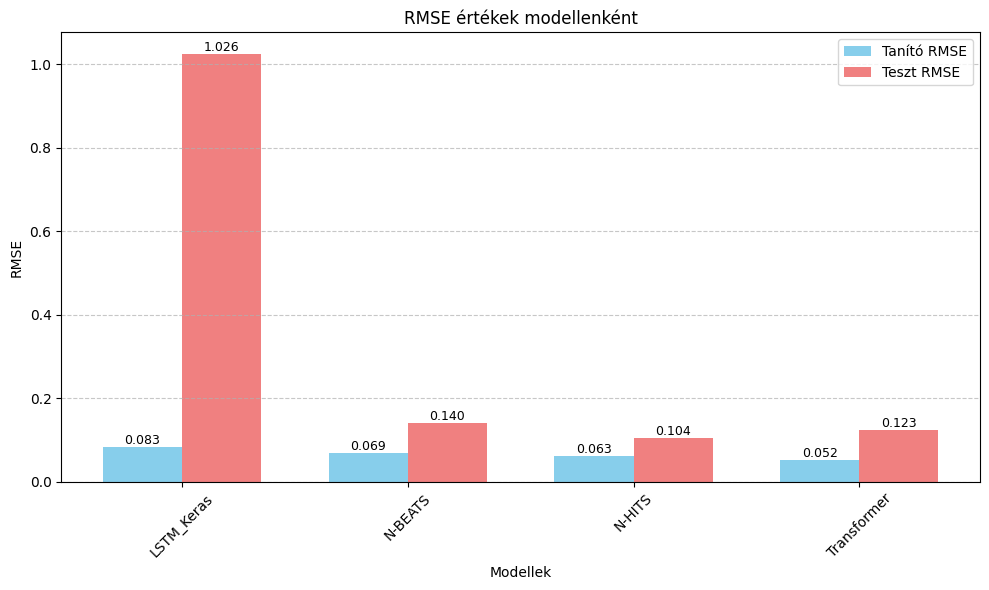

In [15]:
import matplotlib.pyplot as plt
import numpy as np

models = list(results.keys())
train_rmse = [results[model]['train_rmse'] for model in models]
val_rmse = [results[model]['test_rmse'] for model in models]

plt.figure(figsize=(10, 6))

x = np.arange(len(models))
width = 0.35  

bars1 = plt.bar(x - width/2, train_rmse, width, label='Tanító RMSE', color='skyblue')
bars2 = plt.bar(x + width/2, val_rmse, width, label='Teszt RMSE', color='lightcoral')

plt.xlabel('Modellek')
plt.ylabel('RMSE')
plt.title('RMSE értékek modellenként')
plt.xticks(x, models, rotation=45)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

for bar in bars1:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, height,
        f'{height:.3f}',
        ha='center', va='bottom', fontsize=9
    )

for bar in bars2:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, height,
        f'{height:.3f}',
        ha='center', va='bottom', fontsize=9
    )

plt.tight_layout()
plt.show()


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


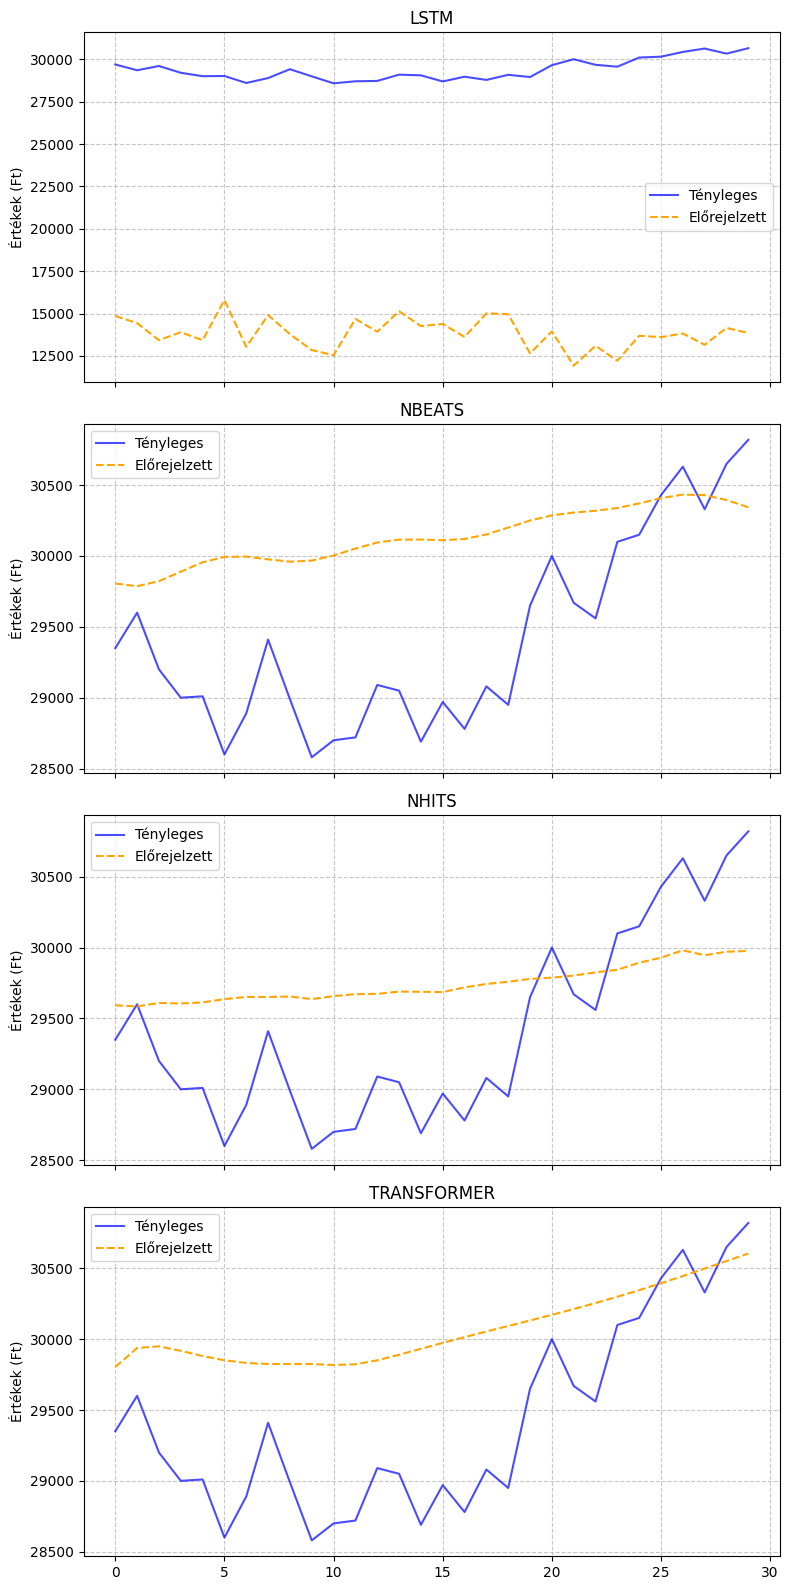

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import joblib

# Assuming model_names is defined as provided
model_names = {"lstm": lstm_model, "nbeats": nbeats_model, "nhits": nhits_model, "transformer": transformer_model}

scaler = joblib.load("../data_pipeline/scaler_model.pkl")

# Initialize dictionaries to store predictions
train_predictions = {}
test_predictions = {}
train_actuals = {}
test_actuals = {}

# Generate predictions for each model
for name in model_names:
    if name == "lstm":
        # LSTM predictions (Keras)
        train_pred = lstm_model.predict(train_X)
        test_pred = lstm_model.predict(test_X)
        # Inverse transform to original scale
        train_predictions[name] = scaler.inverse_transform(train_pred)[-1]
        test_predictions[name] = scaler.inverse_transform(test_pred)[-1]
        train_actuals[name] = scaler.inverse_transform(train_y)[-1]
        test_actuals[name] = scaler.inverse_transform(test_y)[-1]
    else:
        # PyTorch-based models (nbeats, nhits, transformer)
        model = model_names[name]
        # Generate predictions
        train_pred = model.predict(train_dataloader).detach().numpy()
        test_pred = model.predict(test_dataloader).detach().numpy()
        # Get actuals
        train_actual = torch.cat([y[0] for x, y in iter(train_dataloader)]).numpy()
        test_actual = torch.cat([y[0] for x, y in iter(test_dataloader)]).numpy()
        train_predictions[name] = scaler.inverse_transform(train_pred)[-1]
        test_predictions[name] = scaler.inverse_transform(test_pred)[-1]
        train_actuals[name] = scaler.inverse_transform(train_actual)[-1]
        test_actuals[name] = scaler.inverse_transform(test_actual)[-1]

fig, axes = plt.subplots(len(model_names), 1, figsize=(8, 4 * len(model_names)), sharex=True)

for idx, name in enumerate(model_names):

    axes[idx].plot(test_actuals[name], label='Tényleges', color='blue', alpha=0.7)
    axes[idx].plot(test_predictions[name], label='Előrejelzett', color='orange', linestyle='--')
    axes[idx].set_title(f'{name.upper()}')
    axes[idx].set_ylabel('Értékek (Ft)')
    axes[idx].legend()
    axes[idx].grid(True, linestyle='--', alpha=0.7)


plt.tight_layout()

plt.show()

In [32]:

conn = sqlite3.connect("../data_pipeline/stock_data.db")

stock_data = pd.read_sql("SELECT * FROM OTP_BD", conn)
conn.close()

print("Data read back from SQL:")
print()
stock_data

Data read back from SQL:



,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Scaled_price,sentiment_score
0,2002-03-05,1346.679102,1404.393921,1335.136138,1404.393921,1726700,0.0,0.0,-1.009421,0.0
1,2002-03-06,1396.057389,1443.511797,1379.384219,1436.457764,898300,0.0,0.0,-1.003618,0.0
2,2002-03-07,1449.924288,1474.934039,1437.098775,1471.727661,763700,0.0,0.0,-0.997235,0.0
3,2002-03-08,1452.489264,1463.390950,1438.381201,1462.108398,402000,0.0,0.0,-0.998976,1.0
4,2002-03-11,1445.435476,1448.641854,1379.384076,1384.514282,439600,0.0,0.0,-1.013019,1.0
...,...,...,...,...,...,...,...,...,...,...
6040,2025-10-15,30200.000000,30640.000000,30200.000000,30430.000000,333078,0.0,0.0,4.243485,2.0
6041,2025-10-16,30450.000000,30780.000000,30360.000000,30630.000000,290776,0.0,0.0,4.279680,1.0
6042,2025-10-17,30350.000000,30480.000000,30130.000000,30330.000000,268702,0.0,0.0,4.225388,2.0
6043,2025-10-20,30410.000000,30750.000000,30410.000000,30650.000000,166529,0.0,0.0,4.283300,0.0


In [81]:
test_set = stock_data[-90:]

test_X = test_set["Scaled_price"][:60].values

real_prices = test_set["Close"][-30:].values

In [58]:
stock_data['time_idx'] = range(len(stock_data))

stock_data["series"] = 0

In [59]:
common_params = dict(
    time_idx="time_idx",
    target="Scaled_price",
    categorical_encoders={"series": NaNLabelEncoder(add_nan=True).fit(stock_data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=["Scaled_price"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
)

In [60]:
test_dataset = TimeSeriesDataSet(
    test_set,
    **common_params
)

test_dataloader = test_dataset.to_dataloader(train=False, batch_size=32, num_workers=0, shuffle=False)

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import joblib

# Define models
model_names = {
    "lstm": lstm_model,
    "nbeats": nbeats_model,
    "nhits": nhits_model,
    "transformer": transformer_model
}

scaler = joblib.load("../data_pipeline/scaler_model.pkl")

test_predictions = {}
# test_actuals = {}

for name in model_names:
    if name == "lstm":
        test_pred = lstm_model.predict(test_X.reshape(1, 60, 1))
        test_predictions[name] = scaler.inverse_transform(test_pred)

    else:
        model = model_names[name]
        # print(model)
        test_pred = model.predict(test_dataloader).detach().numpy()

        test_predictions[name] = scaler.inverse_transform(test_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


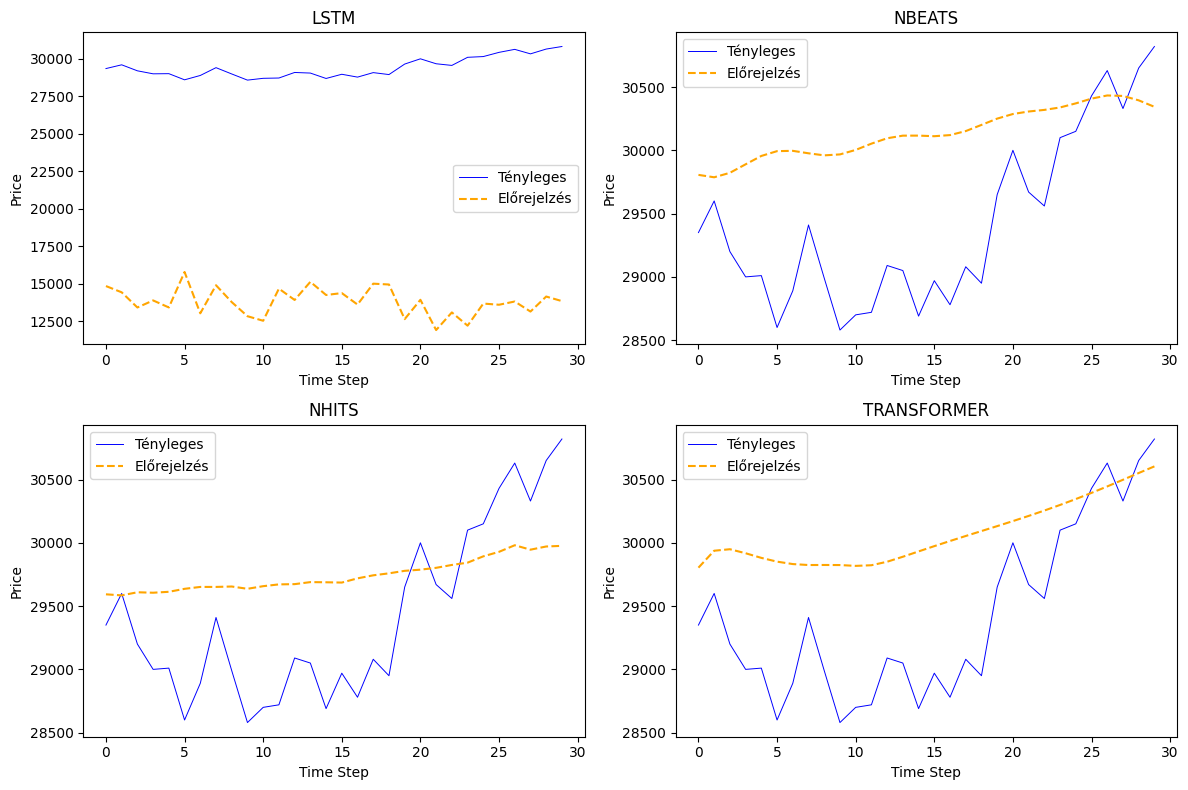


📊 Model Performance Comparison:
                      MSE      RMSE  MAPE (%)
Model                                        
LSTM         2.445224e+08  15637.21     52.94
NBEATS       8.000748e+05    894.47      2.67
NHITS        4.186284e+05    647.01      1.96
TRANSFORMER  6.221111e+05    788.74      2.34


In [84]:
pred_df = pd.DataFrame({model: preds.flatten() for model, preds in test_predictions.items()})
pred_df['real'] = real_prices

# Plot each model vs real
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, (model, preds) in enumerate(test_predictions.items()):
    ax = axes[i]
    ax.plot(real_prices, label='Tényleges', color='blue', linewidth=0.7)
    ax.plot(preds.flatten(), label=f'Előrejelzés', color='orange', linestyle='--')
    ax.set_title(model.upper())
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price')
    ax.legend()

plt.tight_layout()
plt.show()

# Calculate metrics
results = []
for model, preds in test_predictions.items():
    y_pred = preds.flatten()
    mse = mean_squared_error(real_prices, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(real_prices, y_pred) * 100
    results.append({'Model': model.upper(), 'MSE': mse, 'RMSE': rmse, 'MAPE (%)': mape})

# Create results table
results_df = pd.DataFrame(results).set_index('Model')
print("\n📊 Model Performance Comparison:")
print(results_df.round(2))

# Tanítás hírek használatával

In [ ]:
import torch
from pytorch_forecasting.models.nbeats import NBeats
from pytorch_forecasting.models.nhits import NHiTS
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from sklearn.preprocessing import StandardScaler
from pytorch_forecasting import TimeSeriesDataSet, NHiTS, NBeats, TemporalFusionTransformer
import sqlite3
import os
import mlflow
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from pytorch_forecasting.data import GroupNormalizer
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping as LSTMEarlyStop


import time

import numpy as np

import matplotlib.pyplot as plt

In [28]:

conn = sqlite3.connect("../data_pipeline/stock_data.db")

stock_data = pd.read_sql("SELECT * FROM OTP_BD", conn)
conn.close()

print("Data read back from SQL:")
print()
stock_data

Data read back from SQL:



,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Scaled_price,sentiment_score
0,2002-03-05,1346.679102,1404.393921,1335.136138,1404.393921,1726700,0.0,0.0,-1.009421,0.0
1,2002-03-06,1396.057389,1443.511797,1379.384219,1436.457764,898300,0.0,0.0,-1.003618,0.0
2,2002-03-07,1449.924288,1474.934039,1437.098775,1471.727661,763700,0.0,0.0,-0.997235,0.0
3,2002-03-08,1452.489264,1463.390950,1438.381201,1462.108398,402000,0.0,0.0,-0.998976,1.0
4,2002-03-11,1445.435476,1448.641854,1379.384076,1384.514282,439600,0.0,0.0,-1.013019,1.0
...,...,...,...,...,...,...,...,...,...,...
6040,2025-10-15,30200.000000,30640.000000,30200.000000,30430.000000,333078,0.0,0.0,4.243485,2.0
6041,2025-10-16,30450.000000,30780.000000,30360.000000,30630.000000,290776,0.0,0.0,4.279680,1.0
6042,2025-10-17,30350.000000,30480.000000,30130.000000,30330.000000,268702,0.0,0.0,4.225388,2.0
6043,2025-10-20,30410.000000,30750.000000,30410.000000,30650.000000,166529,0.0,0.0,4.283300,0.0


In [29]:
stock_data['time_idx'] = range(len(stock_data))

stock_data["series"] = 0

In [ ]:
mlflow.set_tracking_uri('http://localhost:5000')

mlflow.set_experiment("Base_models_sentiment")


train_cutoff = int(len(stock_data) * 0.8)
max_encoder_length = 60
max_prediction_length = 30

common_params = dict(
    time_idx="time_idx",
    target="Scaled_price",
    categorical_encoders={"series": NaNLabelEncoder(add_nan=True).fit(stock_data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=["Scaled_price"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["Sentiment"]
)

train_val_data = stock_data[stock_data.time_idx <= train_cutoff]
test_data = stock_data[stock_data.time_idx > train_cutoff]


val_cutoff = int(train_val_data["time_idx"].quantile(0.9))  # last 10% time index

train_dataset = TimeSeriesDataSet(
    train_val_data[train_val_data.time_idx <= val_cutoff],
    **common_params
)

val_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    train_val_data[train_val_data.time_idx > val_cutoff],
    predict=True,
    stop_randomization=True
)

test_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    test_data,
    predict=True,
    stop_randomization=True
)


train_dataloader = train_dataset.to_dataloader(train=True, batch_size=32, num_workers=0)
val_dataloader = val_dataset.to_dataloader(train=False, batch_size=32, num_workers=0)
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=32, num_workers=0)

models = {
    "LSTM_Keras": None,
    "N-BEATS": NBeats,
    "N-HITS": NHiTS,
    "Transformer": TemporalFusionTransformer
}

results = {}

for model_name, model_class in models.items():
    with mlflow.start_run(run_name=model_name):
        print(f"\n=== Training {model_name} ===")
        if model_name == "LSTM_Keras":
            # Prepare LSTM Data
            series = stock_data['Scaled_price'].values

            def create_sequences(series, start_idx, end_idx):
                X, y = [], []
                for i in range(start_idx + max_encoder_length, end_idx - max_prediction_length):
                    X.append(series[i - max_encoder_length:i])
                    y.append(series[i:i + max_prediction_length])
                return np.array(X), np.array(y)

            train_X, train_y = create_sequences(series, 0, train_cutoff)
            test_X, test_y = create_sequences(series, train_cutoff, len(series))

            train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))

            # Build Model
            lstm_model = Sequential([
                Input(shape = (max_encoder_length, 1)),
                LSTM(units = 50, return_sequences = True),
                LSTM(50),
                Dense(max_prediction_length, activation='linear')
            ])
            lstm_model.compile(loss = 'mean_squared_error', optimizer = 'adam')
            lstm_model.fit(train_X, train_y,  epochs=15, batch_size=20, 
                    verbose=1, validation_split=0.1,)

            # Training Evaluation
            train_pred = lstm_model.predict(train_X)
            train_rmse = mean_squared_error(train_y, train_pred)

            # Validation Evaluation
            test_pred = lstm_model.predict(test_X)
            test_rmse = mean_squared_error(test_y, test_pred)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.keras.log_model(lstm_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
            lstm_model.save('models/lstm_model_sentiment.keras')
        
        elif model_name == "N-BEATS":
            nbeats_model = NBeats.from_dataset(  
                train_dataset,  
                learning_rate=1e-3,  
                weight_decay=1e-3,  
                widths=[256, 512],  
                backcast_loss_ratio=0.1,  
                num_blocks=[4,4],  
                num_block_layers=[4,4], 
            )
            trainer = Trainer(max_epochs=20, gradient_clip_val=0.1, logger=False, enable_checkpointing=False)
            trainer.fit(nbeats_model, train_dataloader)

            actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
            predictions = nbeats_model.predict(train_dataloader)
            train_rmse = root_mean_squared_error(actuals, predictions[:len(actuals)])

            test_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
            test_predictions = nbeats_model.predict(val_dataloader)
            test_rmse = root_mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mse = mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mape = mean_absolute_percentage_error(test_actuals, test_predictions[:len(test_actuals)])
            # test_rmse = np.sqrt(torch.mean((test_actuals - test_predictions[:len(test_actuals)]) ** 2)).item()

            total_params = sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.log_metric("test_mse", test_mse)
            mlflow.log_metric("test_mape", test_mape)
            mlflow.log_metric("total_parameters", total_params)
            mlflow.pytorch.log_model(nbeats_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
            torch.save(nbeats_model.state_dict(), "models/nbeats_weights_sentiment.pth")

        elif model_name == "N-HITS":
            nhits_model = NHiTS.from_dataset(
                train_dataset,
                learning_rate=1e-3,  
                log_interval=10,  
                log_val_interval=1,  
                weight_decay=0.001,  
                n_blocks=[3, 3, 3],  
                n_layers=2,  
                hidden_size=512,  
                dropout=0.1,  
            )
            trainer = Trainer(max_epochs=20, gradient_clip_val=0.1, logger=False, enable_checkpointing=False)
            trainer.fit(nhits_model, train_dataloader)

            actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
            predictions = nhits_model.predict(train_dataloader)
            train_rmse = np.sqrt(torch.mean((actuals - predictions[:len(actuals)]) ** 2)).item()

            val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
            test_predictions = nhits_model.predict(val_dataloader)
            test_rmse = root_mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mse = mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mape = mean_absolute_percentage_error(test_actuals, test_predictions[:len(test_actuals)])
            # test_rmse = np.sqrt(torch.mean((test_actuals - test_predictions[:len(test_actuals)]) ** 2)).item()

            total_params = sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.log_metric("test_mse", test_mse)
            mlflow.log_metric("test_mape", test_mape)
            mlflow.log_metric("total_parameters", total_params)
            mlflow.pytorch.log_model(nhits_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
            torch.save(nhits_model.state_dict(), "models/nhits_weights_sentiment.pth")

        else:
            # PyTorch Forecasting Models
            transformer_model = TemporalFusionTransformer.from_dataset(
                train_dataset,
                hidden_size=64,
                lstm_layers=1,
                dropout=0.15,
                attention_head_size=4,
                learning_rate=1e-3
            )
            trainer = Trainer(max_epochs=20, gradient_clip_val=0.1, logger=False, enable_checkpointing=False)
            trainer.fit(transformer_model, train_dataloader)

            # Training Evaluation
            actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
            predictions = transformer_model.predict(train_dataloader)
            train_rmse = np.sqrt(torch.mean((actuals - predictions[:len(actuals)]) ** 2)).item()


            # Validation Evaluation
            val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
            test_predictions = transformer_model.predict(val_dataloader)
            test_rmse = root_mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mse = mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mape = mean_absolute_percentage_error(test_actuals, test_predictions[:len(test_actuals)])
            # test_rmse = np.sqrt(torch.mean((test_actuals - test_predictions[:len(test_actuals)]) ** 2)).item()

            total_params = sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.log_metric("test_mse", test_mse)
            mlflow.log_metric("test_mape", test_mape)
            mlflow.log_metric("total_parameters", total_params)
            mlflow.pytorch.log_model(transformer_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
            torch.save(transformer_model.state_dict(), "models/transformer_weights_sentiment.pth")

print("\n=== RMSE Results ===")
for model_name, rmse_values in results.items():
    print(f"{model_name} => Train RMSE: {rmse_values['train_rmse']:.4f}, Val RMSE: {rmse_values['val_rmse']:.4f}")
